### Importing the Libraries

In [2]:
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import (train_test_split, 
                                     cross_val_score, 
                                     RandomizedSearchCV, 
                                     GridSearchCV)

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.metrics import (accuracy_score, 
                             f1_score, 
                             precision_score, 
                             recall_score, 
                             RocCurveDisplay,
                             precision_recall_curve, 
                             average_precision_score,
                             roc_auc_score, 
                             roc_curve, auc)

from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [3]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


### Establishing the connection to the Database

In [5]:
dbname = 'loan_management'
user = 'postgres'
password = 'simi280498'
host = '127.0.0.1'
port = '5432'

In [6]:
#Establishing the connection
engine = create_engine(f'postgresql://{user}:{password}@{host}/{dbname}')

### Extracting the data from the tables

In [8]:
# Define your SELECT query
query = '''SELECT * FROM borrower as b 
         inner join loan_to_income as lti 
         on b.borrower_id = lti.borrower_id 
         inner join loan as l
         on lti.loan_id = l.loan_id'''

In [9]:
df = pd.read_sql_query(query, engine)
print("Data loaded successfully!")

Data loaded successfully!


### Closing the connection

In [11]:
engine.dispose()

### Separating Features and Target Value

In [13]:
df.head()

,borrower_id,age,income,credit_score,months_employed,num_credit_lines,dti_ratio,education,employment_type,marital_status,...,has_cosigner,loan_id,borrower_id,loan_amount_to_income,loan_id,loan_amount,interest_rate,loan_term,loan_purpose,defaulter
0,BI38PQUQS96,56,85994,520,80,4,0.44,Bachelor's,Full-time,Divorced,...,1,I38PQUQS96,BI38PQUQS96,0.588262,I38PQUQS96,50587,15.23,36,Other,0
1,BHPSK72WA7R,69,50432,458,15,1,0.68,Master's,Full-time,Married,...,1,HPSK72WA7R,BHPSK72WA7R,2.467481,HPSK72WA7R,124440,4.81,60,Other,0
2,BC1OZ6DPJ8Y,46,84208,451,26,3,0.31,Master's,Unemployed,Divorced,...,0,C1OZ6DPJ8Y,BC1OZ6DPJ8Y,1.534154,C1OZ6DPJ8Y,129188,21.17,24,Auto,1
3,BV2KKSFM3UN,32,31713,743,0,3,0.23,High School,Full-time,Married,...,0,V2KKSFM3UN,BV2KKSFM3UN,1.412638,V2KKSFM3UN,44799,7.07,24,Business,0
4,BEY08JDHTZP,60,20437,633,8,4,0.73,Bachelor's,Unemployed,Divorced,...,0,EY08JDHTZP,BEY08JDHTZP,0.447179,EY08JDHTZP,9139,6.51,48,Auto,0


In [14]:
X = df.drop(['defaulter', 'loan_id', 'borrower_id'], axis=1)
y = df['defaulter']

In [15]:
X.head()

,age,income,credit_score,months_employed,num_credit_lines,dti_ratio,education,employment_type,marital_status,income_per_credit_line,has_mortgage,has_dependents,has_cosigner,loan_amount_to_income,loan_amount,interest_rate,loan_term,loan_purpose
0,56,85994,520,80,4,0.44,Bachelor's,Full-time,Divorced,21498.500000,1,1,1,0.588262,50587,15.23,36,Other
1,69,50432,458,15,1,0.68,Master's,Full-time,Married,50432.000000,0,0,1,2.467481,124440,4.81,60,Other
2,46,84208,451,26,3,0.31,Master's,Unemployed,Divorced,28069.333333,1,1,0,1.534154,129188,21.17,24,Auto
3,32,31713,743,0,3,0.23,High School,Full-time,Married,10571.000000,0,0,0,1.412638,44799,7.07,24,Business
4,60,20437,633,8,4,0.73,Bachelor's,Unemployed,Divorced,5109.250000,0,1,0,0.447179,9139,6.51,48,Auto


### One-hot encoding categorical columns

In [17]:
X_encoded = pd.get_dummies(X, drop_first=True)

In [18]:
X_encoded.head()

,age,income,credit_score,months_employed,num_credit_lines,dti_ratio,income_per_credit_line,has_mortgage,has_dependents,has_cosigner,...,education_PhD,employment_type_Part-time,employment_type_Self-employed,employment_type_Unemployed,marital_status_Married,marital_status_Single,loan_purpose_Business,loan_purpose_Education,loan_purpose_Home,loan_purpose_Other
0,56,85994,520,80,4,0.44,21498.500000,1,1,1,...,False,False,False,False,False,False,False,False,False,True
1,69,50432,458,15,1,0.68,50432.000000,0,0,1,...,False,False,False,False,True,False,False,False,False,True
2,46,84208,451,26,3,0.31,28069.333333,1,1,0,...,False,False,False,True,False,False,False,False,False,False
3,32,31713,743,0,3,0.23,10571.000000,0,0,0,...,False,False,False,False,True,False,True,False,False,False
4,60,20437,633,8,4,0.73,5109.250000,0,1,0,...,False,False,False,True,False,False,False,False,False,False


### Checking the class distribution in the target column

In [20]:
print("\nDistribution of classes in y:")
print(y.value_counts())


Distribution of classes in y:
defaulter
0    225694
1     29653
Name: count, dtype: int64


### Balancing the data using SMOTE

In [22]:
smote = SMOTE(random_state=10)

In [23]:
X_resampled, y_resampled = smote.fit_resample(X_encoded,y)

In [24]:
print("\nDistribution of classes in y:")
print(y_resampled.value_counts())


Distribution of classes in y:
defaulter
0    225694
1    225694
Name: count, dtype: int64


### Data Standardization

In [26]:
scaler = StandardScaler()

In [27]:
X_scaled = scaler.fit_transform(X_resampled)

In [28]:
X_train,X_test,y_train,y_test=train_test_split(X_scaled,y_resampled,random_state=42,test_size=0.20)

In [138]:
X_test.shape

(90278, 26)

### 1. Random Forest Classification

In [30]:
# Define the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=400,max_samples=None)

In [31]:
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=400)

In [32]:
# Predict on the test set and evaluate performance
y_pred_rf = rf_classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_rf)

# Print evaluation metrics for Random Forest classifier
print("Random Forest Classifier:")
print("Test Accuracy:", accuracy_rf)
print("Test Precision:", precision_rf)
print("Test Recall:", recall_rf)
print("Test ROC AUC:", roc_auc_rf)

Random Forest Classifier:
Test Accuracy: 0.9176322027515009
Test Precision: 0.9531388363688581
Test Recall: 0.8790808555724786
Test ROC AUC: 0.9177727790925206


In [33]:
report_rf = classification_report(y_test, y_pred_rf)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print('---------------------------------------------------')

print("Classification Report:")
print(report_rf)

Confusion Matrix:
[[43017  1958]
 [ 5478 39825]]
---------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92     44975
           1       0.95      0.88      0.91     45303

    accuracy                           0.92     90278
   macro avg       0.92      0.92      0.92     90278
weighted avg       0.92      0.92      0.92     90278



### 2. KNN Classification

#### 1. Neighbors = 3, Metric = Euclidean

In [36]:
knn_classifier1 = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
knn_classifier1.fit(X_train,y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

In [37]:
# Predict on the test set and evaluate performance
y_pred_knn1 = knn_classifier1.predict(X_test)
accuracy_knn1 = accuracy_score(y_test, y_pred_knn1)
precision_knn1 = precision_score(y_test, y_pred_knn1)
recall_knn1 = recall_score(y_test, y_pred_knn1)
roc_auc_knn1 = roc_auc_score(y_test, y_pred_knn1)

# Print evaluation metrics for K-Nearest Neighbor classifier
print("K-Nearest Neighbors Classifier:")
print("Test Accuracy:", accuracy_knn1)
print("Test Precision:", precision_knn1)
print("Test Recall:", recall_knn1)
print("Test ROC AUC:", roc_auc_knn1)

K-Nearest Neighbors Classifier:
Test Accuracy: 0.8844125922151577
Test Precision: 0.8835863586358635
Test Recall: 0.8864534357548065
Test ROC AUC: 0.8844051503398824


In [38]:
report_knn1 = classification_report(y_test, y_pred_knn1)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn1))

print('---------------------------------------------------')

print("Classification Report:")
print(report_knn1)

Confusion Matrix:
[[39684  5291]
 [ 5144 40159]]
---------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88     44975
           1       0.88      0.89      0.89     45303

    accuracy                           0.88     90278
   macro avg       0.88      0.88      0.88     90278
weighted avg       0.88      0.88      0.88     90278



#### 2. Neighbors = 5, Metric = Euclidean

In [40]:
knn_classifier2 = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn_classifier2.fit(X_train,y_train)

KNeighborsClassifier(metric='euclidean')

In [41]:
# Predict on the test set and evaluate performance
y_pred_knn2 = knn_classifier2.predict(X_test)
accuracy_knn2 = accuracy_score(y_test, y_pred_knn2)
precision_knn2 = precision_score(y_test, y_pred_knn2)
recall_knn2 = recall_score(y_test, y_pred_knn2)
roc_auc_knn2 = roc_auc_score(y_test, y_pred_knn2)

# Print evaluation metrics for K-Nearest Neighbor classifier
print("K-Nearest Neighbors Classifier:")
print("Test Accuracy:", accuracy_knn2)
print("Test Precision:", precision_knn2)
print("Test Recall:", recall_knn2)
print("Test ROC AUC:", roc_auc_knn2)

K-Nearest Neighbors Classifier:
Test Accuracy: 0.8846895146104256
Test Precision: 0.8936218216275974
Test Recall: 0.8742908858133015
Test ROC AUC: 0.8847274329010921


In [42]:
report_knn2 = classification_report(y_test, y_pred_knn2)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn2))

print('---------------------------------------------------')

print("Classification Report:")
print(report_knn2)

Confusion Matrix:
[[40260  4715]
 [ 5695 39608]]
---------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89     44975
           1       0.89      0.87      0.88     45303

    accuracy                           0.88     90278
   macro avg       0.88      0.88      0.88     90278
weighted avg       0.88      0.88      0.88     90278



### 3. Neighbors = 3, Metric = Cosine

In [44]:
knn_classifier3 = KNeighborsClassifier(n_neighbors=3, metric='cosine')
knn_classifier3.fit(X_train,y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=3)

In [45]:
# Predict on the test set and evaluate performance
y_pred_knn3 = knn_classifier3.predict(X_test)
accuracy_knn3 = accuracy_score(y_test, y_pred_knn3)
precision_knn3 = precision_score(y_test, y_pred_knn3)
recall_knn3 = recall_score(y_test, y_pred_knn3)
roc_auc_knn3 = roc_auc_score(y_test, y_pred_knn3)

# Print evaluation metrics for K-Nearest Neighbor classifier
print("K-Nearest Neighbors Classifier:")
print("Test Accuracy:", accuracy_knn3)
print("Test Precision:", precision_knn3)
print("Test Recall:", recall_knn3)
print("Test ROC AUC:", roc_auc_knn3)

K-Nearest Neighbors Classifier:
Test Accuracy: 0.8872704313343228
Test Precision: 0.8891818826449212
Test Recall: 0.8857470807672781
Test ROC AUC: 0.8872759861868631


In [46]:
report_knn3 = classification_report(y_test, y_pred_knn3)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn3))

print('---------------------------------------------------')

print("Classification Report:")
print(report_knn3)

Confusion Matrix:
[[39974  5001]
 [ 5176 40127]]
---------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     44975
           1       0.89      0.89      0.89     45303

    accuracy                           0.89     90278
   macro avg       0.89      0.89      0.89     90278
weighted avg       0.89      0.89      0.89     90278



#### 4. Neighbors = 5, Metric = Cosine

In [48]:
knn_classifier4 = KNeighborsClassifier(n_neighbors=5, metric='cosine')
knn_classifier4.fit(X_train,y_train)

KNeighborsClassifier(metric='cosine')

In [49]:
# Predict on the test set and evaluate performance
y_pred_knn4 = knn_classifier4.predict(X_test)
accuracy_knn4 = accuracy_score(y_test, y_pred_knn4)
precision_knn4 = precision_score(y_test, y_pred_knn4)
recall_knn4 = recall_score(y_test, y_pred_knn4)
roc_auc_knn4 = roc_auc_score(y_test, y_pred_knn4)

# Print evaluation metrics for K-Nearest Neighbor classifier
print("K-Nearest Neighbors Classifier:")
print("Test Accuracy:", accuracy_knn4)
print("Test Precision:", precision_knn4)
print("Test Recall:", recall_knn4)
print("Test ROC AUC:", roc_auc_knn4)

K-Nearest Neighbors Classifier:
Test Accuracy: 0.8868495092935156
Test Precision: 0.8998541343787037
Test Recall: 0.8715096130499084
Test ROC AUC: 0.8869054457689786


In [50]:
report_knn4 = classification_report(y_test, y_pred_knn4)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn4))

print('---------------------------------------------------')

print("Classification Report:")
print(report_knn4)

Confusion Matrix:
[[40581  4394]
 [ 5821 39482]]
---------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.89     44975
           1       0.90      0.87      0.89     45303

    accuracy                           0.89     90278
   macro avg       0.89      0.89      0.89     90278
weighted avg       0.89      0.89      0.89     90278



### 3. XGBoost Classifier

In [52]:
xgb_classifier = XGBClassifier(n_estimators=400)
xgb_classifier.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [53]:
# Predict on the test set and evaluate performance
y_pred_xgb = xgb_classifier.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_xgb)

# Print evaluation metrics for XGBoost classifier
print("XGBoost Classifier:")
print("Test Accuracy:", accuracy_xgb)
print("Test Precision:", precision_xgb)
print("Test Recall:", recall_xgb)
print("Test ROC AUC:", roc_auc_xgb)

XGBoost Classifier:
Test Accuracy: 0.9264604887126432
Test Precision: 0.9781124795963793
Test Recall: 0.872988543805046
Test ROC AUC: 0.9266554725695603


In [54]:
report_xgb = classification_report(y_test, y_pred_xgb)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

print('---------------------------------------------------')

print("Classification Report:")
print(report_xgb)

Confusion Matrix:
[[44090   885]
 [ 5754 39549]]
---------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93     44975
           1       0.98      0.87      0.92     45303

    accuracy                           0.93     90278
   macro avg       0.93      0.93      0.93     90278
weighted avg       0.93      0.93      0.93     90278



### ROC Curve

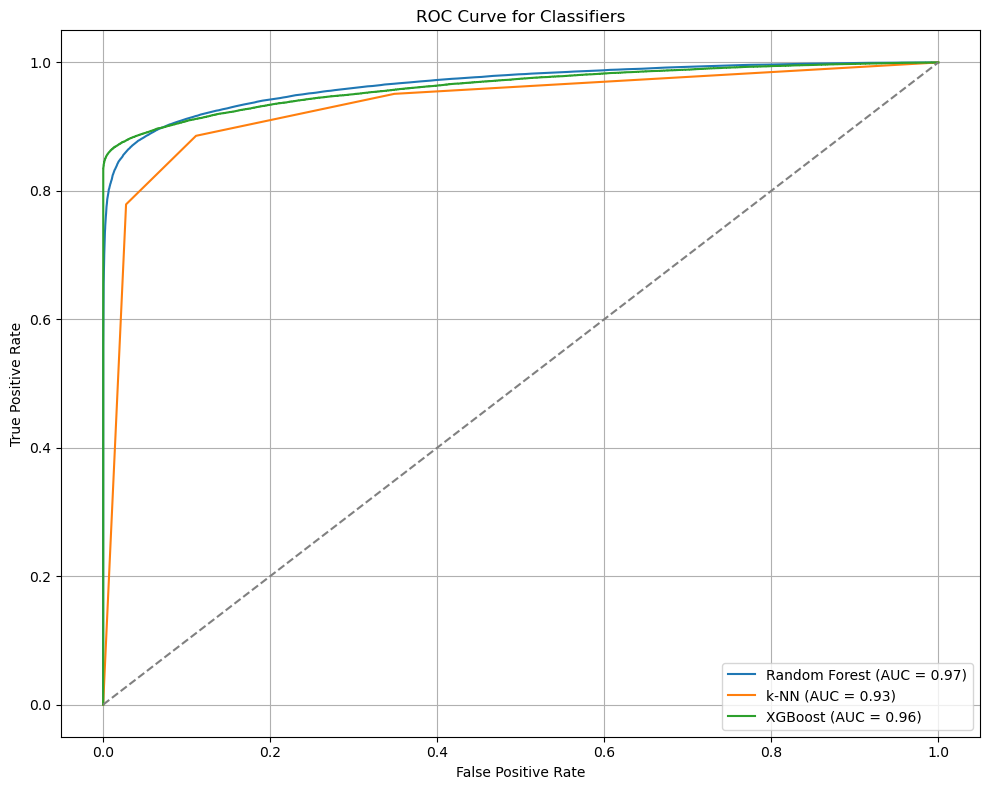

In [56]:
# Define a dictionary to store classifiers
classifiers = {
    'Random Forest': rf_classifier,
    'k-NN': knn_classifier3,
    'XGBoost': xgb_classifier,
}

# Create a figure for ROC curves
plt.figure(figsize=(10, 8))

# Iterate through each classifier and plot its ROC curve
for clf_name, clf in classifiers.items():
    # Make predictions on the test set to obtain probabilities
    y_prob = clf.predict_proba(X_test)[:, 1]
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    
    # Calculate ROC AUC score
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # Plot ROC curve for each 
    plt.plot(fpr, tpr, label=f'{clf_name} (AUC = {roc_auc:.2f})')

# Plot the diagonal (random guess line)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Add labels and title to the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Classifiers')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('ROC Curve after SMOTE and Standardization.png')
plt.grid(True)
plt.show()

### Precision - Recall Curve

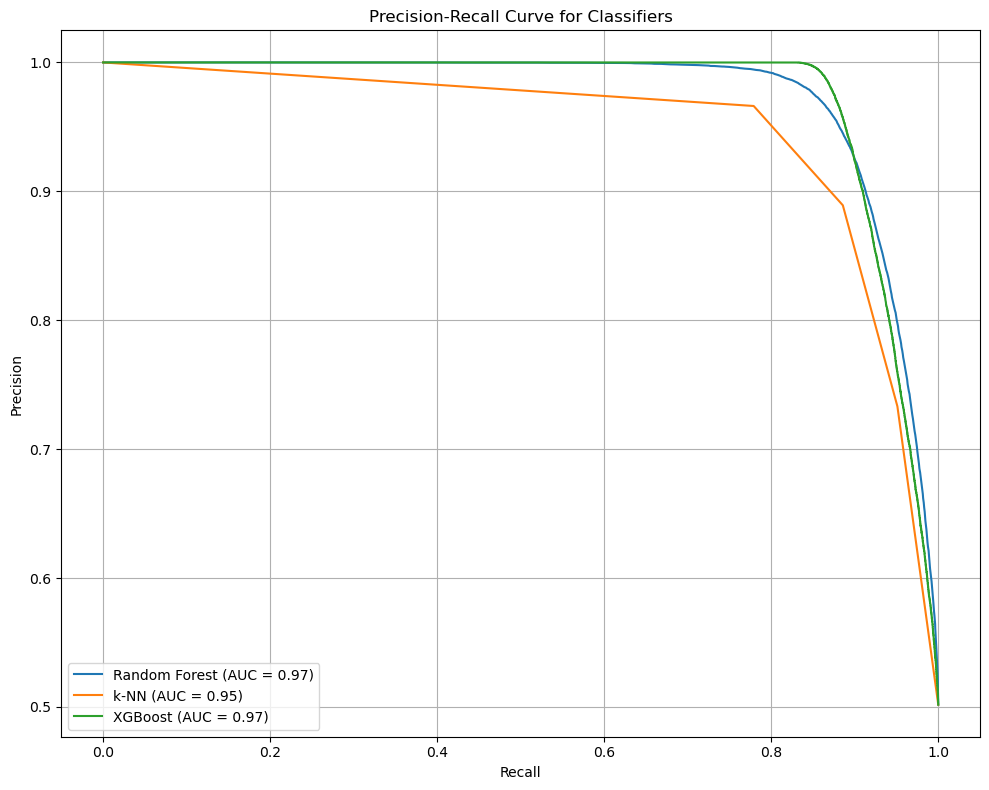

In [58]:
# Define a dictionary to store classifiers
classifiers = {
    'Random Forest': rf_classifier,
    'k-NN': knn_classifier3,
    'XGBoost': xgb_classifier,   
}

# Create a figure for PR curves
plt.figure(figsize=(10, 8))

# Iterate through each classifier and plot its PR curve
for clf_name, clf in classifiers.items():
    # Make predictions on the test set to obtain probabilities
    y_prob = clf.predict_proba(X_test)[:, 1]
    
    # Compute precision-recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    
    # Calculate PR AUC score
    pr_auc = auc(recall, precision)
    
    # Plot PR curve for each classifier
    plt.plot(recall, precision, label=f'{clf_name} (AUC = {pr_auc:.2f})')

# Add labels and title to the plot
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Classifiers')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.savefig('Precision-Recall after SMOTE and Standardization.png')
plt.show()

### Testing with Random Data

In [60]:
df_test_1 = pd.read_excel('Final Testing.xlsx')

In [61]:
df_test_1

,age,income,credit_score,months_employed,num_credit_lines,dti_ratio,education,employment_type,marital_status,income_per_credit_line,has_mortgage,has_dependents,has_cosigner,loan_amount_to_income,loan_amount,interest_rate,loan_term,loan_purpose,defaulter
0,18,23994,688,4,1,0.39,High School,Part-time,Divorced,23994.000000,1,1,1,7.547845,181103,21.26,12,Business,1
1,25,26990,387,57,2,0.58,Master's,Unemployed,Married,13495.000000,0,1,0,5.107188,137843,15.82,12,Auto,1
2,30,111951,571,108,4,0.83,PhD,Self-employed,Married,27987.750000,1,1,0,1.151611,128924,14.64,48,Business,1
3,45,90796,736,21,4,0.51,Bachelor's,Unemployed,Divorced,22699.000000,1,0,0,1.070212,97171,20.93,24,Education,1
4,45,51841,397,1,4,0.83,Bachelor's,Unemployed,Married,12960.250000,0,1,0,3.336568,172971,24.78,12,Home,1
5,55,97254,528,15,2,0.36,High School,Part-time,Divorced,48627.000000,0,0,0,1.964495,191055,24.90,36,Auto,1
6,28,149227,375,56,3,0.80,PhD,Full-time,Divorced,49742.333333,0,0,1,0.936553,139759,5.84,36,Education,1
7,29,70149,493,43,2,0.24,PhD,Full-time,Single,35074.500000,1,1,0,0.920270,64556,5.09,24,Home,1
8,29,49031,764,28,1,0.79,Master's,Full-time,Single,49031.000000,0,0,0,1.081663,53035,19.11,12,Other,1


In [62]:
test_1_X = df_test_1.drop(['defaulter'], axis=1)
test_1_y = df_test_1['defaulter']

In [63]:
test_1_X_encoded = pd.get_dummies(test_1_X, drop_first=True)

In [64]:
test_1_X_encoded

,age,income,credit_score,months_employed,num_credit_lines,dti_ratio,income_per_credit_line,has_mortgage,has_dependents,has_cosigner,...,education_PhD,employment_type_Part-time,employment_type_Self-employed,employment_type_Unemployed,marital_status_Married,marital_status_Single,loan_purpose_Business,loan_purpose_Education,loan_purpose_Home,loan_purpose_Other
0,18,23994,688,4,1,0.39,23994.000000,1,1,1,...,False,True,False,False,False,False,True,False,False,False
1,25,26990,387,57,2,0.58,13495.000000,0,1,0,...,False,False,False,True,True,False,False,False,False,False
2,30,111951,571,108,4,0.83,27987.750000,1,1,0,...,True,False,True,False,True,False,True,False,False,False
3,45,90796,736,21,4,0.51,22699.000000,1,0,0,...,False,False,False,True,False,False,False,True,False,False
4,45,51841,397,1,4,0.83,12960.250000,0,1,0,...,False,False,False,True,True,False,False,False,True,False
5,55,97254,528,15,2,0.36,48627.000000,0,0,0,...,False,True,False,False,False,False,False,False,False,False
6,28,149227,375,56,3,0.80,49742.333333,0,0,1,...,True,False,False,False,False,False,False,True,False,False
7,29,70149,493,43,2,0.24,35074.500000,1,1,0,...,True,False,False,False,False,True,False,False,True,False
8,29,49031,764,28,1,0.79,49031.000000,0,0,0,...,False,False,False,False,False,True,False,False,False,True


In [65]:
test_1_X_scaled = scaler.fit_transform(test_1_X_encoded)

In [66]:
test_1_X_scaled.shape

(9, 26)

In [67]:
# Predict on the test set and evaluate performance
y_pred_xgb = xgb_classifier.predict(test_1_X_scaled)
accuracy_xgb = accuracy_score(test_1_y, y_pred_xgb)
precision_xgb = precision_score(test_1_y, y_pred_xgb)
recall_xgb = recall_score(test_1_y, y_pred_xgb)
#roc_auc_xgb = roc_auc_score(test_1_y, y_pred_xgb)

# Print evaluation metrics for XGBoost classifier
print("XGBoost Classifier:")
print(y_pred_xgb)
print("Test Accuracy:", accuracy_xgb)
print("Test Precision:", precision_xgb)
print("Test Recall:", recall_xgb)
#print("Test ROC AUC:", roc_auc_xgb)

XGBoost Classifier:
[1 1 1 1 1 1 1 1 1]
Test Accuracy: 1.0
Test Precision: 1.0
Test Recall: 1.0
